In [1]:
# Basic example loading images from the svhn dataset
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np, random
from torchvision.utils import make_grid, save_image
import torch 
import torch.nn as nn
import torchvision
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.models import vgg19
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook as tqdm  #tqdm representation enables us to be able to follow the value changes during a certain epoch in training and testing, and provides a more intuitive way of "printing" results than simple print
import warnings
warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive')
path = '/content/drive/Shareddrives/DeepLearning/Final Project/'
data_path = '/content/drive/Shareddrives/DeepLearning/Final Project/Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(27648,)


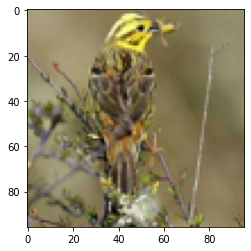

In [2]:
cuda = torch.cuda.is_available()

# load pretrained models
load_pretrained_models = True
# number of epochs of training
n_epochs = 10
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# high res. image height
hr_height = 96
# high res. image width
hr_width = 96
# number of image channels
channels = 3
# image shape
hr_shape = (hr_height, hr_width)

train_mat = sio.loadmat(data_path + 'train.mat')
images = train_mat['X'][0]
print(images.shape)
image_n = images.reshape(3,hr_height,hr_width).transpose(1,2,0)
image_n = np.rot90(image_n, k=3)

plt.imshow(image_n)

In [3]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataDir = data_path + 'train.mat', hr_shape = (96,96)):
        self.hr_height, self.hr_width = hr_shape
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']

        #Transform high resolution images (96x96) to low resolution images (24x24) and compose all together to the desired ToTensor format
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((self.hr_height // 4, self.hr_width // 4)),
                transforms.ToTensor(),
            ]
        )

        #Simply transform and compose high resolution images (96x96) to the desired ToTensor format
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((self.hr_height, self.hr_width)),
                transforms.ToTensor(),
            ]
        )
    
    def __getitem__(self, index):
        data = self.data[index]
        data = data.reshape(3,self.hr_height,self.hr_width).transpose(1,2,0)
        data = np.rot90(data, k=3)
        data = Image.fromarray(data, mode='RGB')
        img_lr = self.lr_transform(data)
        img_hr = self.hr_transform(data)
        return img_lr, img_hr
        pass

    def __len__(self):
        return len(self.data)

In [4]:
#As we said in the presentation we did not execute the code in the cluster because there were some libraries missing (not installed), for example "tqdm"

#In order to execute the code in collaborate session the dataset has to be reduced by a factor (varies according to resources)
'''NOTE: If you run out of Cuda memory for GPU execution when doing training or testing, you can try to increase the parameter N. Also, if you have this problem try to mantain a low batch_size such as 16 and not increase epochs.
And, most importantly, remember to RESTART EXECUTION ENVIRONMENT at each execution (to empty cuda memory)'''
N = 10 
train_dataset = ImageDataset(dataDir = data_path + 'train.mat', hr_shape=(96,96))
train_dataset.data = train_dataset.data[:len(train_dataset)//N]
test_dataset = ImageDataset(dataDir = data_path + 'test.mat', hr_shape=(96,96))
test_dataset.data = test_dataset.data[:len(test_dataset)//N]

In [5]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, # Indicate the used dataset
                                           batch_size=batch_size, # Number of images that will be loaded for iteration
                                           shuffle=True) # Sequential or random data loading

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, # Indicate the used dataset
                                           batch_size=batch_size, # Number of images that will be loaded for iteration
                                           shuffle=True) # Sequential or random data loading

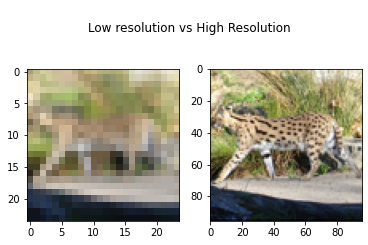

In [6]:
img_lr, img_hr = next(iter(train_dataloader))
fig, axs = plt.subplots(1,2)
fig.suptitle('\nLow resolution vs High Resolution')
axs[0].imshow(transforms.ToPILImage(mode='RGB')(img_lr[0]))
axs[1].imshow(transforms.ToPILImage(mode='RGB')(img_hr[0]))

In [7]:
#We use a pretrained vgg19 network to compute the loss
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)

#Following the model of SRResnet (implemented in SRGANs) we define the residual blocks composed by a conv2d,BatchNorm2d, PReLU, Conv2d and BatchNorm2d
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer, composed by a convolution and a PReLU following the architecture scheme
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual block concatenation
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second convolutional layer composed by a convolution and batchnorm
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers, each one composed by a convolution, a batchnorm, a PixelShuffle and a PReLU.
        upsampling = []
        for out_features in range(2):
            upsampling += [
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer, composed by convolution and tanh
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        #Discriminator blocks composed by a concatenation of two sets of convolution, batchnorm and LeakyRelu (in the first block, batchnorm is ommited as shown in architecture) (will be concatenated to conform major part of discriminator)
        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        #Concatenate all the parts in a single discriminator model
        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [8]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, hr_height, hr_width))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses computation tools
#Creates a criterion that measures the mean squared error between each element in the input xx and target yy.
criterion_GAN = torch.nn.MSELoss()
#Creates a criterion that measures the mean absolute error (MAE) between each element in the input x and target y
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load('/content/drive/Shareddrives/DeepLearning/Final Project/saved_models/generator.pth'))
    discriminator.load_state_dict(torch.load('/content/drive/Shareddrives/DeepLearning/Final Project/saved_models/discriminator.pth'))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [9]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
for epoch in range(n_epochs):

    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, (imgs_lr, imgs_hr) in enumerate(tqdm_bar):
        generator.train(); discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs_lr.type(Tensor))
        imgs_hr = Variable(imgs_hr.type(Tensor))
        # Adversarial ground truth and transformation to the appropiate format
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

In [10]:
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]
for epoch in range(n_epochs):

    # Testing
    gen_loss, disc_loss, rec_error, rec_error_avg = 0, 0, 0, 0 
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, (imgs_lr, imgs_hr) in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()
        # Configure model input
        imgs_lr = Variable(imgs_lr.type(Tensor))
        imgs_hr = Variable(imgs_hr.type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        ### Eval Generator
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        ### Eval Discriminator
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        gen_loss += loss_G.item()
        disc_loss += loss_D.item()
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

        # Save image grid with upsampled inputs and SRGAN outputs
        if random.uniform(0,1)<0.05:
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr_=gen_hr
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
            save_image(img_grid, path+f"output_images/{batch_idx}.png", normalize=False)
    
    #Error/Loss final computation (this is done just for clearity and to obtain a clearer (than with tqdm) output result of the loss between images)
    rec_error = (imgs_hr-gen_hr).abs().mean()
    rec_error_avg += rec_error.cpu().item()
    
print("\n\nAverage epoch reconstruction error: ", rec_error_avg/n_epochs)




Average epoch reconstruction error:  0.03262559473514557
